# BIGBRAIN fine-tuning with Quantization and LoRA Adapters 🧠




## Setup
bitsandbytes > for quantization
datasets > for loading the dataset
loralib > for LoRA adapters
transformers > for the model and tokenizer
accelerate > for distributed training
peft > for LoRA adapters and quantization

In [1]:
from huggingface_hub import notebook_login

In [2]:
from google.colab import drive
drive.mount('/content/drive') # Run if you want to use Google Drive

Mounted at /content/drive


In [3]:
!pip install -q bitsandbytes datasets accelerate loralib
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Prepari

In [33]:
notebook_login()

In [5]:
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-269f6413-0643-12da-9e68-ef2cb8b4aad3)


### Setup the model

In [28]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, BitsAndBytesConfig
import datasets
import transformers
from transformers import Trainer
from peft import LoraConfig, get_peft_model, LoftQConfig, PeftModel

In [10]:
def load_model():
    try:
        # 4 bit quantization
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16
        )

        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            low_cpu_mem_usage=True,
            quantization_config=bnb_config
        )

        return model
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [11]:
model_id = "mistralai/Mistral-7B-v0.1"
model = load_model()
tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    padding_side="left",
    add_eos_token=True
)

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

### Freezing the original weights


In [12]:
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

### Setting up the LoRa Adapters

In [13]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()

    trainable_percentage = 100 * trainable_params / all_param

    print(f"🔍 Total parameters in the model: {all_param}")
    print(f"🚀 Trainable parameters: {trainable_params}")
    print(f"📊 Percentage of trainable parameters: {trainable_percentage:.2f}%")

In [16]:
config = LoraConfig(
    r=16, #attention heads
    lora_alpha=8, #alpha scaling
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM" # set this for CLM or Seq2Seq
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

🔍 Total parameters in the model: 3765702656
🚀 Trainable parameters: 13631488
📊 Percentage of trainable parameters: 0.36%


## Data

In [17]:
data = datasets.load_dataset("csv", data_files="/content/drive/MyDrive/bigbrain-dataset.csv", sep=";")

Generating train split: 0 examples [00:00, ? examples/s]

In [18]:
data['train'][0]

{'instruction': "Tu es un analyseur de données chargé d'aider les étudiants à trouver des ressources, répond au mieux en format JSON.",
 'input': "Comment calculer la dérivée d'une fonction polynomiale ?",
 'output': '{"subject": "maths", "topic": "derivatives"}',
 'text': 'Comment calculer la dérivée d\'une fonction polynomiale ?->: {"subject": "maths", "topic": "derivatives"}'}

In [19]:
data = data.map(lambda samples: tokenizer(samples['text']), batched=True)
data

Map:   0%|          | 0/3392 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'text', 'input_ids', 'attention_mask'],
        num_rows: 3392
    })
})

In [20]:
data['train'].features

{'instruction': Value(dtype='string', id=None),
 'input': Value(dtype='string', id=None),
 'output': Value(dtype='string', id=None),
 'text': Value(dtype='string', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

### Training

In [24]:
# Create a data collator for language modeling.
data_collator = transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
tokenizer.pad_token = tokenizer.eos_token

def train_model():
    # Create a trainer.
    trainer = Trainer(
        model=model,
        train_dataset=data['train'],
        args=transformers.TrainingArguments(
            per_device_train_batch_size=4,
            gradient_accumulation_steps=5,
            warmup_steps=5,
            max_steps=200,
            bf16=True,
            logging_dir="./log",
            learning_rate=2e-5,
            logging_steps=1,
            output_dir='Phearion'
        ),
        data_collator=data_collator,
    )

    # Silence the warnings.
    model.config.use_cache = True
    trainer.train()

    return trainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
trainer = train_model()

Step,Training Loss
1,1.193200
2,1.195200
3,1.144500
4,1.146400
5,1.218400
6,1.145500
7,1.114600
8,1.105400
9,0.986700
10,1.017100


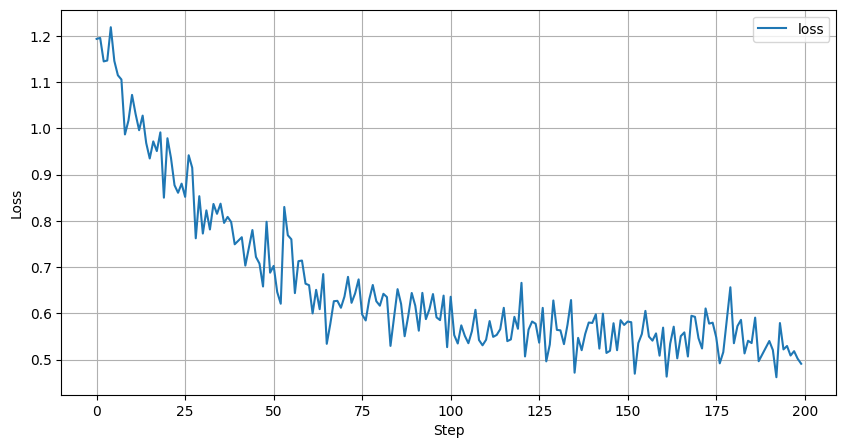

In [25]:
import matplotlib.pyplot as plt

# Assuming 'trainer' is your Trainer object
trainer_state = trainer.state

# Extract the loss values
loss_values = [entry['loss'] for entry in trainer_state.log_history[:-1]]

# Create a range of steps
steps = list(range(len(loss_values)))

# Plot the loss values
plt.figure(figsize=(10, 5))
plt.plot(steps, loss_values, label='loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
trainer.save_model('Phearion/bigbrain-v0.0.1')

In [29]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.bfloat16,
)
model = PeftModel.from_pretrained(base_model, "Phearion/bigbrain-v0.0.1")
model = model.merge_and_unload()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [31]:
# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

In [34]:
model.push_to_hub("phearion/bigbrain-v0.0.1", max_shard_size="2GB")
tokenizer.push_to_hub("phearion/bigbrain-v0.0.1")

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

Upload 8 LFS files:   0%|          | 0/8 [00:00<?, ?it/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Phearion/bigbrain-v0.0.1/commit/1a0204e03168d9ce7ef08907006549d308ef4cec', commit_message='Upload tokenizer', commit_description='', oid='1a0204e03168d9ce7ef08907006549d308ef4cec', pr_url=None, pr_revision=None, pr_num=None)

## Share adapters on the 🤗 Hub

## Load adapters from the Hub

In [35]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available!")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU.")

peft_model_id = "phearion/bigbrain-v0.0.1"
config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, return_dict=True)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Load the Lora model
model = PeftModel.from_pretrained(model, peft_model_id)

GPU is available!


adapter_config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/27.3M [00:00<?, ?B/s]

## Inference

In [43]:
batch = tokenizer("“aide moi avec les equa diff ” ->: ", return_tensors='pt')
with torch.cuda.amp.autocast():
  output_tokens = model.generate(**batch, max_new_tokens=15)

print('\n\n', tokenizer.decode(output_tokens[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




 “aide moi avec les equa diff ” ->:  {"subject": "maths", "topic": "differentials"}
